# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:


1. **Numerical Processing** - Log-transform `Total_Income`, `LoanAmount`. Apply Standard Scaling or MinMaxScaler to the transformed numerical features. 
2. **Categorical Processing** - One-Hot Encoding to the remaining categorical features  (e.g., Gender, Married, Education, Property_Area, etc.). 
3. **Feature Engineering** - Drop the non-predictive Loan_ID. Create Total_Income = ApplicantIncome + CoapplicantIncome.
4. **Feature Selection** - Keep high-signal features, evaluate low-signal ones
6. **Target Handling** - Classification approach with stratified splits


- **High-signal features**: `ApplicantIncome`, `CoapplicantIncome`.
- **Low-signal features**: `LoanAmount`
- **Skewed Variables**: `ApplicantIncome`, `CoapplicantIncome`. (log-transform)
- **Feature Engineering**- Total-Income

### **1. Import Libraries and Data Loading**


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

#Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:

file_path = 'df1_copy_saved.csv'

df_loaded = pd.read_csv(file_path)

print("CSV file loaded successfully!")
print(f"Loaded DataFrame shape: {df_loaded.shape}")
print("\nFirst 5 rows of the loaded DataFrame:")
print(df_loaded.head())

CSV file loaded successfully!
Loaded DataFrame shape: (614, 12)

First 5 rows of the loaded DataFrame:
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No           5849.0   
1   Male     Yes          1      Graduate            No           4583.0   
2   Male     Yes          0      Graduate           Yes           3000.0   
3   Male     Yes          0  Not Graduate            No           2583.0   
4   Male      No          0      Graduate            No           6000.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area Loa

### **2. EDA-Based Data Quality Assessment**

In [27]:
# Creating a copy for preprocessing
df_processed = df_loaded.copy()

# Convert Loan_Status to numeric (Y=1, N=0)
if df_processed['Loan_Status'].dtype == 'object':
    df_processed['Loan_Status'] = df_processed['Loan_Status'].map({'Y': 1, 'N': 0})
    

# 1. Checking for missing values (EDA showed no missing values)
print("\n1. Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")

# 3. Checking skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")




# 4. Correlation with target (EDA Evidence)
print("\n4. Correlation with Loan_Status (EDA Evidence):")
numeric_df = df_processed.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['Loan_Status'].sort_values()

# Display high-signal and low-signal features
print("High-signal features (|correlation| > 0.2):")
high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status')
for feature, corr in high_signal.items():
    print(f"  {feature}: {corr:.3f}")

print("\nLow-signal features (|correlation| < 0.1):")
low_signal = correlations[abs(correlations) < 0.1]
for feature, corr in low_signal.items():
    print(f"  {feature}: {corr:.3f}")
    



1. Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 1
Percentage of duplicates: 0.16%

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 1.037 (right-skewed)
CoapplicantIncome: skewness = 1.010 (right-skewed)
LoanAmount: skewness = 0.682 (right-skewed)

4. Correlation with Loan_Status (EDA Evidence):
High-signal features (|correlation| > 0.2):
  Credit_History: 0.541

Low-signal features (|correlation| < 0.1):
  LoanAmount: -0.047
  Loan_Amount_Term: -0.023
  ApplicantIncome: -0.000
  CoapplicantIncome: 0.012


### **3. Handle Duplicates**

In [7]:
# Removing duplicates if any 
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("✓ No duplicates to remove (as expected from EDA)")


Removing 1 duplicate rows...
Dataset shape after removing duplicates: (613, 12)


### **4. Log-Transform Skewed Variables (EDA Recommendation)**

In [8]:
# Log-transform skewed variables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

# Variables to log-transform based on EDA findings
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for var in skewed_vars:
    if var in df_processed.columns:
        # Check if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <= 0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log(df_processed[var])
            print(f"✓ {var}: Applied log transformation")
        
        # Check skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])


=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ ApplicantIncome: Applied log transformation
  Original skewness: 1.042 → Transformed skewness: -0.597
✓ CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
  Original skewness: 1.008 → Transformed skewness: -0.188
✓ LoanAmount: Applied log transformation
  Original skewness: 0.683 → Transformed skewness: -0.941

Dataset shape after log transformation: (613, 15)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


### **5. Outlier Treatment**

In [9]:
# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
print("EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points")

# Define numerical columns (excluding target)
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()


print(f"Treating outliers in {len(numerical_cols)} numerical features...")

# Apply IQR-capping method
outliers_capped = 0
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    
    if outliers_before > 0:
        # Cap outliers
        df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
        df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
        outliers_capped += outliers_before
        print(f"✓ {col}: Capped {outliers_before} outliers")

print(f"\nTotal outliers capped: {outliers_capped}")
print(f"Dataset shape after outlier treatment: {df_processed.shape}")


=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points
Treating outliers in 8 numerical features...
✓ ApplicantIncome: Capped 50 outliers
✓ LoanAmount: Capped 40 outliers
✓ Loan_Amount_Term: Capped 88 outliers
✓ Credit_History: Capped 89 outliers
✓ ApplicantIncome_log: Capped 6 outliers
✓ LoanAmount_log: Capped 18 outliers

Total outliers capped: 291
Dataset shape after outlier treatment: (613, 15)


### **6. Feature Engineering**



Implementing the specific feature engineering recommendations from the EDA report.

In [11]:
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")

#Total_Income (EDA Referenced Stable Predictor)
df_processed['Total_Income'] = df_processed['ApplicantIncome'] + df_processed['CoapplicantIncome']
print("- Total_Income: ApplicantIncome + CoapplicantIncome")

print(f"\nDataset shape after feature engineering: {df_processed.shape}")
print(f"New engineered features: {[col for col in df_processed.columns if col not in df.columns]}")


FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS
- Total_Income: ApplicantIncome + CoapplicantIncome

Dataset shape after feature engineering: (613, 16)
New engineered features: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income']


### **7. Feature Selection**

In [13]:
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# Separate features and target
X = df_processed.drop(columns= ['Loan_Status'])
y = df_processed['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

print(f"Total features available: {X.shape[1]}")

# EDA-identified high-signal features (|correlation| > 0.2)
high_signal_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
print(f"\nEDA-identified high-signal features: {high_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1) 
low_signal_features = ['Credit_History', 'Loan_Amount_Term']
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are actually available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# Create feature sets for evaluation
print("\n=== FEATURE SETS FOR EVALUATION ===")

# Set 1: All original features (excluding low-signal)
features_exclude_low_signal = [col for col in X.columns if col not in low_signal_features]
print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = available_high_signal + [col for col in X.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Let's use Set 2 (high-signal + engineered) as recommended by EDA
selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)

=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 15

EDA-identified high-signal features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
EDA-identified low-signal features: ['Credit_History', 'Loan_Amount_Term']

Available high-signal features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Available low-signal features: ['Credit_History', 'Loan_Amount_Term']

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Exclude low-signal features: 13 features
Set 2 - High-signal + engineered: 7 features
Set 3 - All features: 15 features

✓ Selected feature set: 7 features
Selected features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income']


### **8. Data Splitting (Stratified)**


Based on EDA findings about class imbalance, use stratified splitting


In [14]:
# Stratified data splitting based on EDA findings about class imbalance
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

# Selecting the chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f}%)")

# Checking class distribution in each set 
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())
print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())


=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (613, 7)

Data split results:
Training set: (367, 7) (59.9%)
Validation set: (123, 7) (20.1%)
Test set: (123, 7) (20.1%)

Class distribution verification:
Training set quality distribution:
Loan_Status
0    115
1    252
Name: count, dtype: int64

Validation set quality distribution:
Loan_Status
0    38
1    85
Name: count, dtype: int64

Test set quality distribution:
Loan_Status
0    39
1    84
Name: count, dtype: int64


### **9. Feature Scaling**


Apply StandardScaler as recommended by EDA for distance-based models.


In [15]:
# Applying StandardScaler as recommended by EDA
print("=== FEATURE SCALING (STANDARD SCALER) ===")
print("EDA recommended StandardScaler for distance-based models")

# Fitting scaler on training data only (to avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied successfully!")
print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

# Verifying scaling worked correctly
print(f"\nScaling verification:")
print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models
✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 1.0014
Validation set scaled - Mean: 0.0098, Std: 1.0605
Test set scaled - Mean: 0.0363, Std: 1.0537

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: True


### **10. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. ApplicantIncome: 0.064
 2. Total_Income: 0.050
 3. ApplicantIncome_log: 0.028
 4. LoanAmount_log: 0.023
 5. CoapplicantIncome_log: 0.016
 6. CoapplicantIncome: 0.013
 7. LoanAmount: 0.007

Engineered features in top 10: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income']


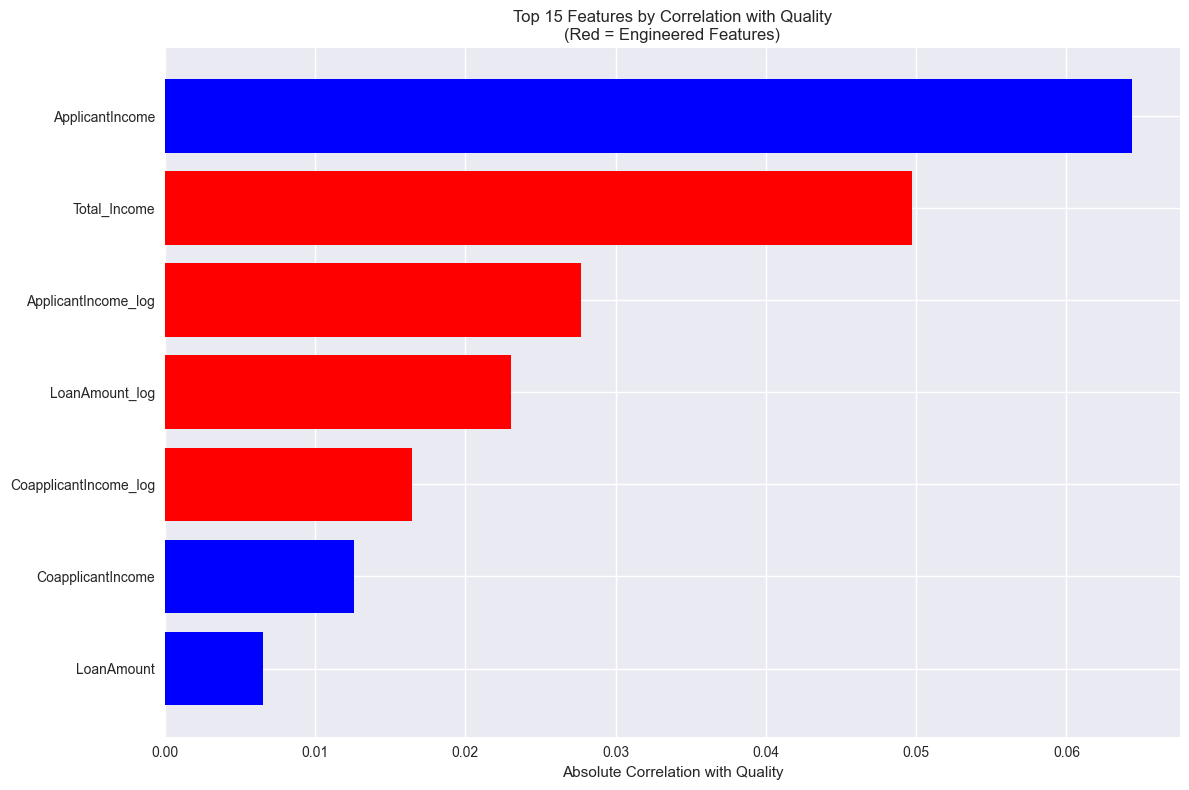


✓ Feature importance analysis completed
✓ 4 engineered features in top 10


In [16]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Quality')
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


### **11. Save Preprocessed Data**


Save all preprocessed datasets and preprocessing objects for modeling

In [17]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_val_scaled.to_csv('X_val_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'val_samples': X_val_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ['residual sugar', 'total sulfur dioxide', 'chlorides']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


### **12. Preprocessing Summary**

In [18]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Validation samples: {X_val_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, duplicates handled)")
print("> Log-transformation of skewed variables (ApplicantIncome, CoapplicantIncome, LoanAmount)")
print("> Outlier treatment using IQR-capping method")
print("> Feature engineering based on EDA recommendations:")
print("  Total_Income (ApplicantIncome + CoapplicantIncome)")
print("> Feature selection (high-signal features + engineered features)")
print("> Stratified data splitting (preserves class distribution)")
print("> StandardScaler applied (EDA recommendation for distance-based models)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> High-signal features prioritized: ApplicantIncome, CoapplicantIncome, LoanAmount")
print("> Low-signal features excluded: Credit_History, Loan_Amount_Term")
print("> Skewed variables log-transformed as recommended")
print("> Total Income created based on bivariate analysis")

print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")


.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (614, 12)
Final processed dataset shape: (613, 16)
Selected features: 7
Training samples: 367
Validation samples: 123
Test samples: 123

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, duplicates handled)
> Log-transformation of skewed variables (ApplicantIncome, CoapplicantIncome, LoanAmount)
> Outlier treatment using IQR-capping method
> Feature engineering based on EDA recommendations:
  Total_Income (ApplicantIncome + CoapplicantIncome)
> Feature selection (high-signal features + engineered features)
> Stratified data splitting (preserves class distribution)
> StandardScaler applied (EDA recommendation for distance-based models)
> Feature importance analysis (validates engineered features)
> Data export (ready for modeling)

.....EDA EVIDENCE IMPLEMENTED.....
> High-signal features prioritized: ApplicantIncome, CoapplicantIncome, LoanAmount
> Low-signal fe